In [1]:
import numpy as np

import matplotlib.pyplot as plt
import os,sys,glob
import cv2
import pickle

sys.path.append("..") 
from models.yolo_models import get_yolo_model

np.set_printoptions(suppress=True)


In [2]:
im_width=864
im_height=864

yolov3 = get_yolo_model(im_width,im_height,num_class=10)

yolov3.load_weights('/home/ctorney/data/weights/aerial-weights.h5')

#yolov3.load_weights('../weights/yolo-v3-coco.h5')

In [3]:
image_name =  '/home/ctorney/data/aerialsurvey/train_images/SWC0138-28.JPG'

#image_name = 'horse_images/DEPTR_170606-8m-361-0.png'
im = cv2.imread(image_name)
im = cv2.resize(im,(864,864))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#im = im[100:516,100:516,:]

In [4]:
%ls ../weights

tiny_coco.h5  yolo-v3-coco.h5


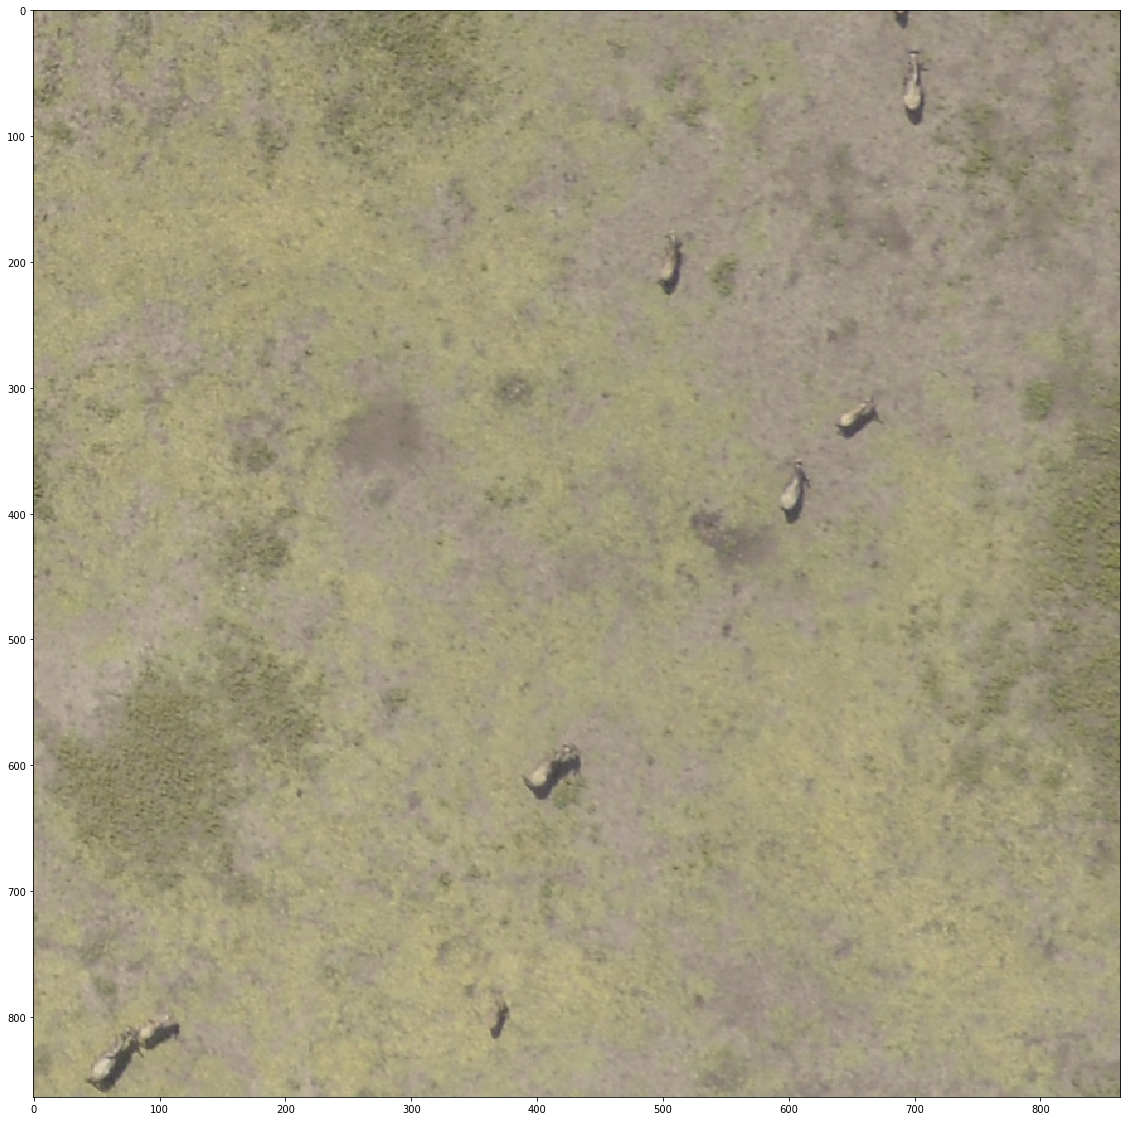

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(im)
plt.show()

In [6]:
new_image = im[:,:,::-1]/255.
new_image = np.expand_dims(new_image, 0)

# get detections
preds = yolov3.predict(new_image)


In [7]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def bbox_iou(box1, box2):
    
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [10]:
nms_threshold=0.1
obj_threshold=0.5
max_length=10000
new_boxes = np.zeros((0,5))
for i in range(3):
    netout=preds[i][0]
    grid_h, grid_w = netout.shape[:2]
    xpos = netout[...,0]
    ypos = netout[...,1]
    wpos = netout[...,2]
    hpos = netout[...,3]

    objectness = netout[...,4]
    
    classes = netout[...,5:]

    # select only objects above threshold
    indexes = (objectness > obj_threshold) & (wpos<max_length) & (hpos<max_length)
    
    print(classes[indexes])
    
    if np.sum(indexes)==0:
        print('no boxes')
        continue
    print(np.argmax(classes[indexes],axis=1))

    corner1 = np.column_stack((xpos[indexes]-wpos[indexes]/2.0, ypos[indexes]-hpos[indexes]/2.0))
    corner2 = np.column_stack((xpos[indexes]+wpos[indexes]/2.0, ypos[indexes]+hpos[indexes]/2.0))


    new_boxes = np.append(new_boxes, np.column_stack((corner1, corner2, objectness[indexes])),axis=0)

# do nms 
sorted_indices = np.argsort(-new_boxes[:,4])
boxes=new_boxes.tolist()

for i in range(len(sorted_indices)):

    index_i = sorted_indices[i]

    if new_boxes[index_i,4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_threshold:
            new_boxes[index_j,4] = 0

new_boxes = new_boxes[new_boxes[:,4]>0]

[]
no boxes
[[0.9978064  0.00010154 0.00009115 0.00012907 0.00091083 0.00032915
  0.00007285 0.0001055  0.00043247 0.00002105]
 [0.9991235  0.00002118 0.00006365 0.00004377 0.00019347 0.00007717
  0.00005227 0.00029603 0.00010131 0.00002757]
 [0.99852544 0.00003988 0.00007888 0.00029468 0.00051606 0.0001026
  0.00003153 0.00007197 0.00032032 0.00001866]
 [0.9990138  0.00004897 0.00013008 0.00010254 0.0003343  0.00006602
  0.00002416 0.00002616 0.00024658 0.00000744]
 [0.9961578  0.00029269 0.00036817 0.00022864 0.00117601 0.00082683
  0.0000897  0.00010874 0.00065747 0.00009387]
 [0.99687177 0.00007034 0.0001482  0.00022169 0.00042949 0.00009505
  0.00020109 0.0014816  0.00032572 0.000155  ]
 [0.9989858  0.00001635 0.00008018 0.00004929 0.00010215 0.00009351
  0.0000586  0.0003341  0.00018017 0.0000999 ]]
[0 0 0 0 0 0 0]
[]
no boxes


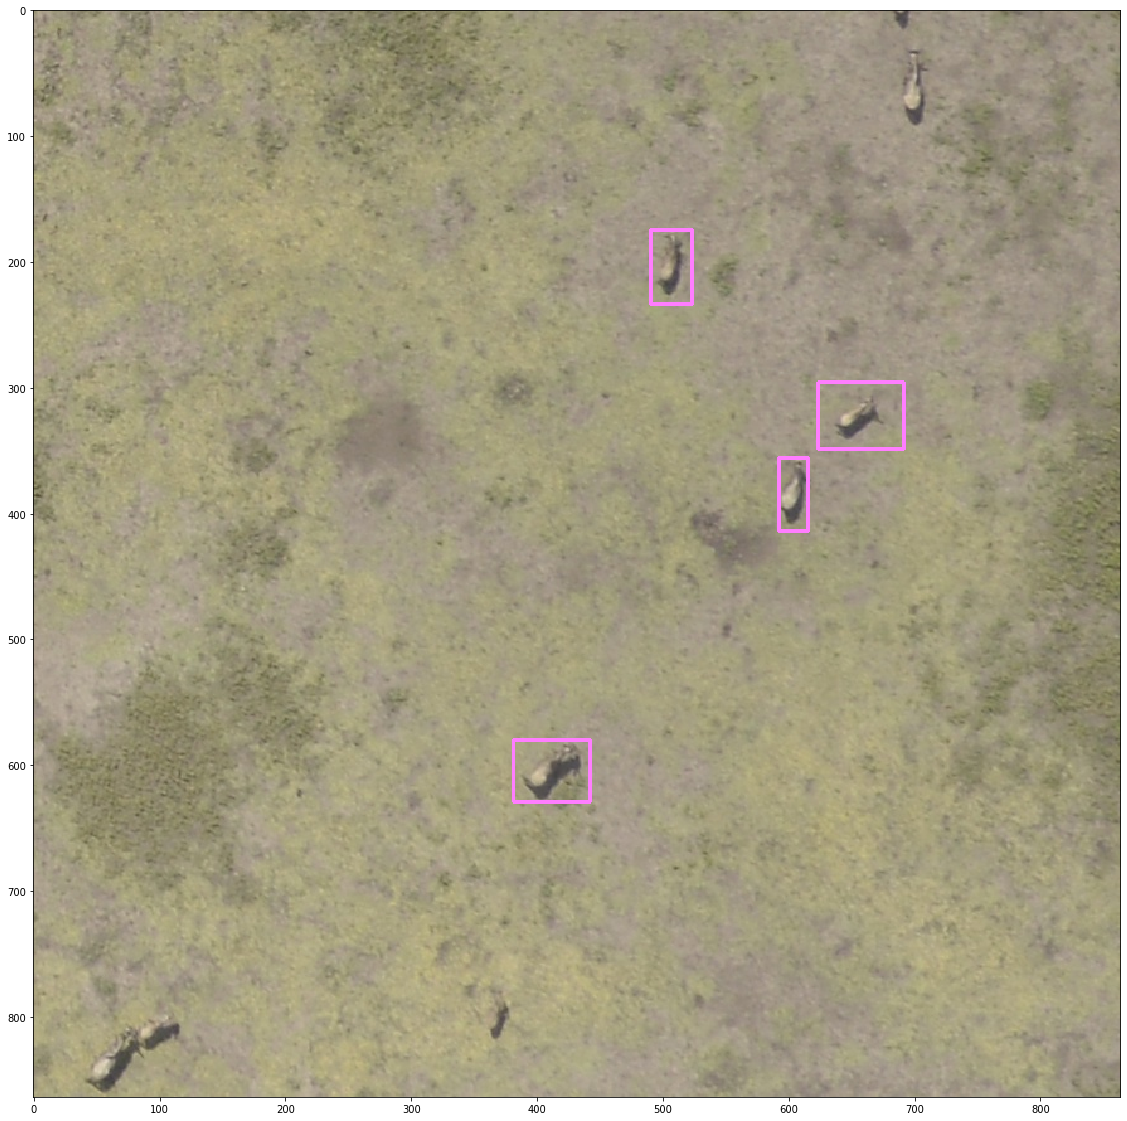

In [11]:

im = cv2.imread(image_name)
#im = im[100:516,100:516,:]
im = cv2.resize(im,(864,864))

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

for box in new_boxes:
    xmin  = int((box[0]))
    xmax  = int((box[2]))
    ymin  = int((box[1]))
    ymax  = int((box[3]))
    
    
    cv2.rectangle(im, (xmin,ymin), (xmax,ymax), (255,125,255), 2)
plt.figure(figsize=(20,20))
plt.imshow(im)
#cv2.imwrite('test.jpg',im)
plt.show()

In [ ]:
preds[0].shape

In [ ]:
np.set_printoptions(suppress=True)
new_boxes

In [ ]:
yolov3.summary()